In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader

import csv
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

grid_size = 11
num_classes = 2  # 2 classes just object and not object
data_length = 875 # starting at 0
train_length = 700

epochs = 100
batch_size = 32

### Model Definition

In [5]:
class MinecraftFoundationModel(nn.Module):
    def __init__(self):
        super(MinecraftFoundationModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove the last two layers
        
        # Object Prediction Head
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(2048, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1),
            nn.Upsample(size=(grid_size * grid_size), mode='bilinear', align_corners=True),
            nn.Softmax(dim=1)
        )
        
        # Depth Estimation Head
        self.depth_estimation_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 121)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        segmentation = self.segmentation_head(features)
        depth = self.depth_estimation_head(features)

        return depth

### Dataset Definition

In [7]:
class MinecraftDepthDataset(Dataset):
    def __init__(self, image_paths, depth_paths, transform=None, train=True):
        self.image_paths = image_paths
        self.depth_paths = depth_paths
        self.transform = transform
        self.trainset = train

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        with open(self.depth_paths[idx], mode='r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)
            rows = list(csv_reader)
            distances = [float(row[1]) for row in rows]

        if self.transform:
            image = self.transform(image)
        
        depth = torch.tensor(distances, dtype=torch.float32)

        return image, depth

weights = models.ResNet50_Weights.DEFAULT
transform = weights.transforms()

image_paths = ['data/Unannotated/image_{}.png'.format(str(i).zfill(5)) for i in range(1, data_length)]
depth_paths = ['data/Annotations/annotation_{}.csv'.format(str(i).zfill(5)) for i in range(1, data_length)]

# Example paths, replace with your actual paths
train_dataset = MinecraftDepthDataset(image_paths[:train_length], depth_paths[:train_length], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

val_dataset = MinecraftDepthDataset(image_paths[train_length:], depth_paths[train_length:], transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

### Training

In [5]:
model = MinecraftFoundationModel().to(device)

depth_loss_fn = nn.MSELoss()
optimizer_backbone = torch.optim.Adam(model.backbone.parameters(), lr=1e-4)
optimizer_depth = torch.optim.Adam(model.depth_estimation_head.parameters(), lr=1e-3)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    # Training step
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        start_time = time.time()
        for i, (images, depth_targets) in enumerate(train_loader):
            images = images.to(device)
            depth_targets = depth_targets.to(device)

            optimizer_backbone.zero_grad()
            optimizer_depth.zero_grad()

            depth_pred = model(images)

            loss = depth_loss_fn(depth_pred, depth_targets)
            loss.backward()
            optimizer_depth.step()
            optimizer_backbone.step()

            train_loss += loss.item() * images.size(0)

            pbar.set_postfix({'loss': loss.item(), 'iter/s': '{:.2f}'.format(i / (time.time() - start_time))})
            pbar.update(1)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, depth_targets in val_loader:
            images = images.to(device)
            depth_targets = depth_targets.to(device)

            depth_pred = model(images)
            loss = depth_loss_fn(depth_pred, depth_targets)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

C:\Users\Evan Goldman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Evan Goldman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/100: 100%|██████████| 22/22 [00:27<00:00,  1.27s/batch, loss=27.5, iter/s=0.75]


Epoch 1/100, Train Loss: 89.6873, Val Loss: 21.6223


Epoch 2/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=14.9, iter/s=0.85]


Epoch 2/100, Train Loss: 16.3842, Val Loss: 13.2822


Epoch 3/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=10.2, iter/s=0.85]


Epoch 3/100, Train Loss: 11.8487, Val Loss: 11.1004


Epoch 4/100: 100%|██████████| 22/22 [00:24<00:00,  1.12s/batch, loss=9.07, iter/s=0.85]


Epoch 4/100, Train Loss: 9.0690, Val Loss: 9.4033


Epoch 5/100: 100%|██████████| 22/22 [00:24<00:00,  1.12s/batch, loss=8.89, iter/s=0.85]


Epoch 5/100, Train Loss: 8.5794, Val Loss: 9.0089


Epoch 6/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=5.33, iter/s=0.85]


Epoch 6/100, Train Loss: 7.7833, Val Loss: 8.5416


Epoch 7/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=7.33, iter/s=0.85]


Epoch 7/100, Train Loss: 7.0007, Val Loss: 8.5622


Epoch 8/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=5.26, iter/s=0.85]


Epoch 8/100, Train Loss: 6.6162, Val Loss: 8.2246


Epoch 9/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.78, iter/s=0.84]


Epoch 9/100, Train Loss: 6.0952, Val Loss: 7.6581


Epoch 10/100: 100%|██████████| 22/22 [00:25<00:00,  1.15s/batch, loss=4.64, iter/s=0.83]


Epoch 10/100, Train Loss: 5.9076, Val Loss: 7.5004


Epoch 11/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=7.61, iter/s=0.85]


Epoch 11/100, Train Loss: 5.7370, Val Loss: 7.3635


Epoch 12/100: 100%|██████████| 22/22 [00:24<00:00,  1.12s/batch, loss=5.07, iter/s=0.85]


Epoch 12/100, Train Loss: 5.5323, Val Loss: 6.9151


Epoch 13/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=6.99, iter/s=0.85]


Epoch 13/100, Train Loss: 5.4826, Val Loss: 7.2262


Epoch 14/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=5.73, iter/s=0.85]


Epoch 14/100, Train Loss: 5.1259, Val Loss: 7.1177


Epoch 15/100: 100%|██████████| 22/22 [00:24<00:00,  1.14s/batch, loss=4.64, iter/s=0.84]


Epoch 15/100, Train Loss: 4.9529, Val Loss: 6.7716


Epoch 16/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.36, iter/s=0.85]


Epoch 16/100, Train Loss: 4.7171, Val Loss: 6.8433


Epoch 17/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.84, iter/s=0.85]


Epoch 17/100, Train Loss: 4.7198, Val Loss: 7.0702


Epoch 18/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=5.28, iter/s=0.85]


Epoch 18/100, Train Loss: 4.6086, Val Loss: 6.7609


Epoch 19/100: 100%|██████████| 22/22 [00:25<00:00,  1.14s/batch, loss=3.55, iter/s=0.84]


Epoch 19/100, Train Loss: 4.5142, Val Loss: 6.7079


Epoch 20/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.89, iter/s=0.85]


Epoch 20/100, Train Loss: 4.5243, Val Loss: 6.7531


Epoch 21/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.56, iter/s=0.85]


Epoch 21/100, Train Loss: 4.3288, Val Loss: 6.4822


Epoch 22/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.14, iter/s=0.85]


Epoch 22/100, Train Loss: 4.3082, Val Loss: 6.8654


Epoch 23/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.05, iter/s=0.85]


Epoch 23/100, Train Loss: 4.2132, Val Loss: 6.4265


Epoch 24/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.35, iter/s=0.85]


Epoch 24/100, Train Loss: 4.2281, Val Loss: 6.4521


Epoch 25/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.44, iter/s=0.85]


Epoch 25/100, Train Loss: 4.1758, Val Loss: 6.5215


Epoch 26/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.75, iter/s=0.85]


Epoch 26/100, Train Loss: 4.0428, Val Loss: 6.4037


Epoch 27/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.17, iter/s=0.85]


Epoch 27/100, Train Loss: 3.8899, Val Loss: 6.3639


Epoch 28/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.02, iter/s=0.85]


Epoch 28/100, Train Loss: 3.8723, Val Loss: 6.4522


Epoch 29/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.18, iter/s=0.85]


Epoch 29/100, Train Loss: 3.8562, Val Loss: 6.3504


Epoch 30/100: 100%|██████████| 22/22 [00:24<00:00,  1.12s/batch, loss=2.94, iter/s=0.85]


Epoch 30/100, Train Loss: 4.0499, Val Loss: 6.5253


Epoch 31/100: 100%|██████████| 22/22 [00:24<00:00,  1.12s/batch, loss=3.83, iter/s=0.85]


Epoch 31/100, Train Loss: 3.8004, Val Loss: 6.2499


Epoch 32/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.33, iter/s=0.85]


Epoch 32/100, Train Loss: 3.7737, Val Loss: 6.3914


Epoch 33/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.59, iter/s=0.84]


Epoch 33/100, Train Loss: 3.6993, Val Loss: 6.2080


Epoch 34/100: 100%|██████████| 22/22 [00:24<00:00,  1.12s/batch, loss=3.65, iter/s=0.85]


Epoch 34/100, Train Loss: 3.6735, Val Loss: 6.2024


Epoch 35/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.29, iter/s=0.85]


Epoch 35/100, Train Loss: 3.7467, Val Loss: 6.1742


Epoch 36/100: 100%|██████████| 22/22 [00:24<00:00,  1.12s/batch, loss=3.17, iter/s=0.85]


Epoch 36/100, Train Loss: 3.7192, Val Loss: 6.3119


Epoch 37/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.89, iter/s=0.85]


Epoch 37/100, Train Loss: 3.6480, Val Loss: 6.2051


Epoch 38/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.75, iter/s=0.85]


Epoch 38/100, Train Loss: 3.6220, Val Loss: 6.1855


Epoch 39/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.96, iter/s=0.85]


Epoch 39/100, Train Loss: 3.5020, Val Loss: 6.3443


Epoch 40/100: 100%|██████████| 22/22 [00:25<00:00,  1.14s/batch, loss=3.51, iter/s=0.84]


Epoch 40/100, Train Loss: 3.5240, Val Loss: 6.1325


Epoch 41/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.84, iter/s=0.85]


Epoch 41/100, Train Loss: 3.5022, Val Loss: 6.0670


Epoch 42/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.98, iter/s=0.85]


Epoch 42/100, Train Loss: 3.4232, Val Loss: 6.0898


Epoch 43/100: 100%|██████████| 22/22 [00:25<00:00,  1.16s/batch, loss=2.82, iter/s=0.83]


Epoch 43/100, Train Loss: 3.4387, Val Loss: 6.2071


Epoch 44/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.09, iter/s=0.84]


Epoch 44/100, Train Loss: 3.4802, Val Loss: 6.1611


Epoch 45/100: 100%|██████████| 22/22 [00:24<00:00,  1.14s/batch, loss=2.76, iter/s=0.84]


Epoch 45/100, Train Loss: 3.4607, Val Loss: 6.1324


Epoch 46/100: 100%|██████████| 22/22 [00:24<00:00,  1.14s/batch, loss=2.98, iter/s=0.84]


Epoch 46/100, Train Loss: 3.4123, Val Loss: 5.9511


Epoch 47/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.71, iter/s=0.84]


Epoch 47/100, Train Loss: 3.3452, Val Loss: 5.9662


Epoch 48/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.05, iter/s=0.84]


Epoch 48/100, Train Loss: 3.3395, Val Loss: 6.0800


Epoch 49/100: 100%|██████████| 22/22 [00:24<00:00,  1.14s/batch, loss=2.97, iter/s=0.84]


Epoch 49/100, Train Loss: 3.3904, Val Loss: 6.0657


Epoch 50/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.12, iter/s=0.84]


Epoch 50/100, Train Loss: 3.3512, Val Loss: 5.8905


Epoch 51/100: 100%|██████████| 22/22 [00:26<00:00,  1.19s/batch, loss=3.23, iter/s=0.80]


Epoch 51/100, Train Loss: 3.3627, Val Loss: 6.0784


Epoch 52/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.39, iter/s=0.84]


Epoch 52/100, Train Loss: 3.4129, Val Loss: 6.0739


Epoch 53/100: 100%|██████████| 22/22 [00:24<00:00,  1.14s/batch, loss=3.46, iter/s=0.84]


Epoch 53/100, Train Loss: 3.3457, Val Loss: 5.9966


Epoch 54/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.92, iter/s=0.84]


Epoch 54/100, Train Loss: 3.3123, Val Loss: 5.9308


Epoch 55/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.11, iter/s=0.84]


Epoch 55/100, Train Loss: 3.2686, Val Loss: 5.8025


Epoch 56/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.89, iter/s=0.84]


Epoch 56/100, Train Loss: 3.2607, Val Loss: 6.0271


Epoch 57/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3, iter/s=0.84]   


Epoch 57/100, Train Loss: 3.2594, Val Loss: 5.8484


Epoch 58/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.03, iter/s=0.84]


Epoch 58/100, Train Loss: 3.2374, Val Loss: 5.9011


Epoch 59/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.47, iter/s=0.84]


Epoch 59/100, Train Loss: 3.2799, Val Loss: 5.9134


Epoch 60/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.4, iter/s=0.84] 


Epoch 60/100, Train Loss: 3.2655, Val Loss: 5.9178


Epoch 61/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.19, iter/s=0.84]


Epoch 61/100, Train Loss: 3.3047, Val Loss: 5.8689


Epoch 62/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=4.3, iter/s=0.84] 


Epoch 62/100, Train Loss: 3.3172, Val Loss: 5.8768


Epoch 63/100: 100%|██████████| 22/22 [00:25<00:00,  1.14s/batch, loss=2.78, iter/s=0.84]


Epoch 63/100, Train Loss: 3.3430, Val Loss: 5.9615


Epoch 64/100: 100%|██████████| 22/22 [00:24<00:00,  1.14s/batch, loss=3.36, iter/s=0.84]


Epoch 64/100, Train Loss: 3.2818, Val Loss: 5.9410


Epoch 65/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.52, iter/s=0.84]


Epoch 65/100, Train Loss: 3.3026, Val Loss: 5.9327


Epoch 66/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.35, iter/s=0.84]


Epoch 66/100, Train Loss: 3.2135, Val Loss: 5.7240


Epoch 67/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.39, iter/s=0.84]


Epoch 67/100, Train Loss: 3.2916, Val Loss: 5.9163


Epoch 68/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.32, iter/s=0.84]


Epoch 68/100, Train Loss: 3.1519, Val Loss: 5.7921


Epoch 69/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.19, iter/s=0.84]


Epoch 69/100, Train Loss: 3.1986, Val Loss: 5.8468


Epoch 70/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.46, iter/s=0.84]


Epoch 70/100, Train Loss: 3.1600, Val Loss: 5.8454


Epoch 71/100: 100%|██████████| 22/22 [00:25<00:00,  1.14s/batch, loss=2.71, iter/s=0.84]


Epoch 71/100, Train Loss: 3.1726, Val Loss: 5.7826


Epoch 72/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2, iter/s=0.84]   


Epoch 72/100, Train Loss: 3.1753, Val Loss: 5.8767


Epoch 73/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.4, iter/s=0.84] 


Epoch 73/100, Train Loss: 3.1395, Val Loss: 5.7513


Epoch 74/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.32, iter/s=0.84]


Epoch 74/100, Train Loss: 3.1365, Val Loss: 5.6748


Epoch 75/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.02, iter/s=0.84]


Epoch 75/100, Train Loss: 3.1573, Val Loss: 5.7275


Epoch 76/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.99, iter/s=0.84]


Epoch 76/100, Train Loss: 3.1146, Val Loss: 5.6399


Epoch 77/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.75, iter/s=0.84]


Epoch 77/100, Train Loss: 3.0863, Val Loss: 5.7012


Epoch 78/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.63, iter/s=0.84]


Epoch 78/100, Train Loss: 3.0489, Val Loss: 5.6202


Epoch 79/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.9, iter/s=0.84] 


Epoch 79/100, Train Loss: 3.0734, Val Loss: 5.7359


Epoch 80/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.15, iter/s=0.84]


Epoch 80/100, Train Loss: 3.0575, Val Loss: 5.6256


Epoch 81/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=2.91, iter/s=0.84]


Epoch 81/100, Train Loss: 3.0511, Val Loss: 5.6933


Epoch 82/100: 100%|██████████| 22/22 [00:24<00:00,  1.14s/batch, loss=3.7, iter/s=0.84] 


Epoch 82/100, Train Loss: 3.0744, Val Loss: 5.7411


Epoch 83/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.3, iter/s=0.84] 


Epoch 83/100, Train Loss: 3.1140, Val Loss: 5.7551


Epoch 84/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.88, iter/s=0.84]


Epoch 84/100, Train Loss: 3.1600, Val Loss: 5.7204


Epoch 85/100: 100%|██████████| 22/22 [00:25<00:00,  1.16s/batch, loss=2.23, iter/s=0.83]


Epoch 85/100, Train Loss: 3.0990, Val Loss: 5.6169


Epoch 86/100: 100%|██████████| 22/22 [00:25<00:00,  1.14s/batch, loss=2.79, iter/s=0.84]


Epoch 86/100, Train Loss: 3.0734, Val Loss: 5.7085


Epoch 87/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.29, iter/s=0.84]


Epoch 87/100, Train Loss: 3.0969, Val Loss: 5.6991


Epoch 88/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.4, iter/s=0.84] 


Epoch 88/100, Train Loss: 3.1092, Val Loss: 5.6577


Epoch 89/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.7, iter/s=0.84] 


Epoch 89/100, Train Loss: 3.0894, Val Loss: 5.7052


Epoch 90/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.32, iter/s=0.84]


Epoch 90/100, Train Loss: 3.0709, Val Loss: 5.7010


Epoch 91/100: 100%|██████████| 22/22 [00:25<00:00,  1.14s/batch, loss=3.04, iter/s=0.84]


Epoch 91/100, Train Loss: 3.0762, Val Loss: 5.6727


Epoch 92/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.6, iter/s=0.84] 


Epoch 92/100, Train Loss: 3.1252, Val Loss: 5.6578


Epoch 93/100: 100%|██████████| 22/22 [00:24<00:00,  1.14s/batch, loss=3.91, iter/s=0.84]


Epoch 93/100, Train Loss: 3.1209, Val Loss: 5.7516


Epoch 94/100: 100%|██████████| 22/22 [00:25<00:00,  1.14s/batch, loss=3.88, iter/s=0.84]


Epoch 94/100, Train Loss: 3.1121, Val Loss: 5.6175


Epoch 95/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.41, iter/s=0.84]


Epoch 95/100, Train Loss: 3.1689, Val Loss: 5.7622


Epoch 96/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.22, iter/s=0.84]


Epoch 96/100, Train Loss: 3.1403, Val Loss: 5.6695


Epoch 97/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.17, iter/s=0.84]


Epoch 97/100, Train Loss: 3.1280, Val Loss: 5.6615


Epoch 98/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.68, iter/s=0.84]


Epoch 98/100, Train Loss: 3.0887, Val Loss: 5.7084


Epoch 99/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.73, iter/s=0.84]


Epoch 99/100, Train Loss: 3.0442, Val Loss: 5.6070


Epoch 100/100: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, loss=3.42, iter/s=0.84]


Epoch 100/100, Train Loss: 3.1288, Val Loss: 5.6781


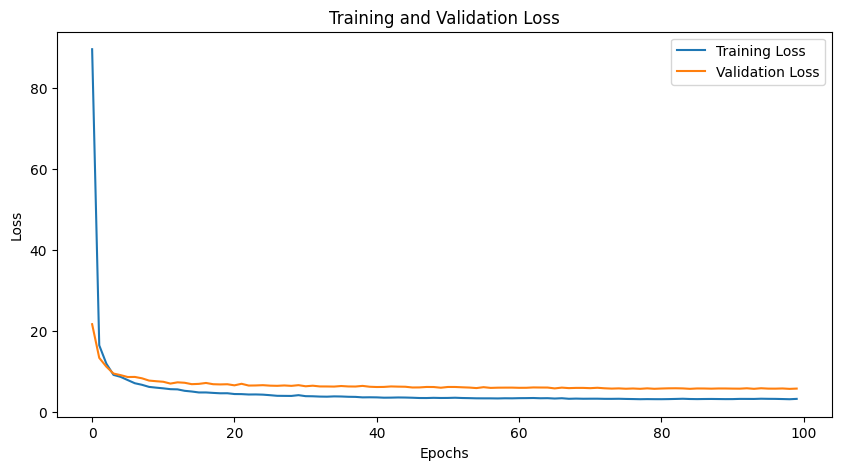

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

C:\Users\Evan Goldman\AppData\Local\Temp\ipykernel_20292\3404334087.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth')

Text(0.5, 1.0, 'Depth Estimation')

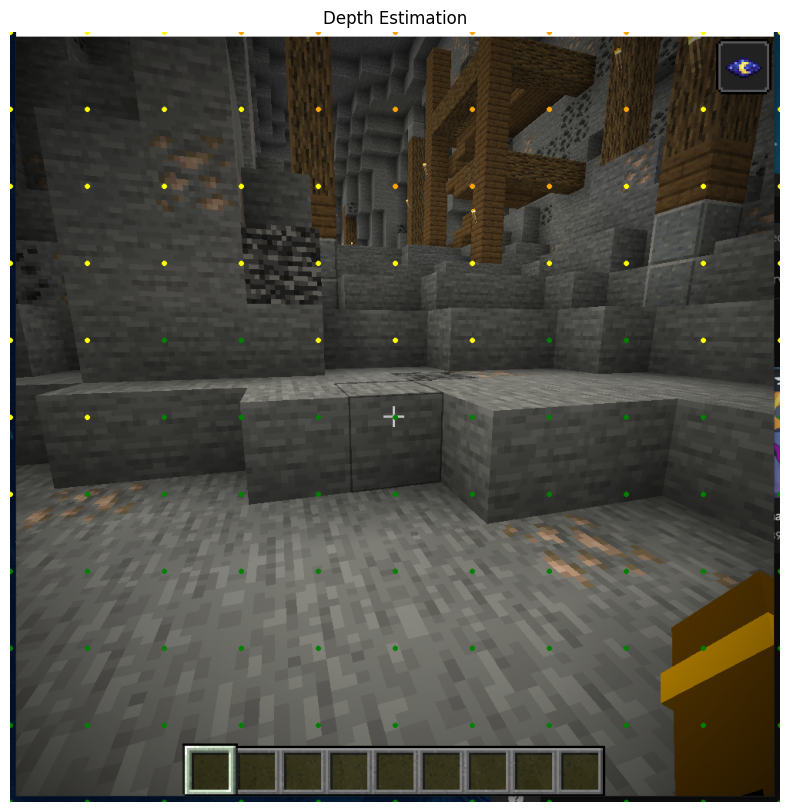

In [11]:
import random

model = MinecraftFoundationModel().to(device)
model.load_state_dict(torch.load('model_weights.pth'))

def get_color(d):
    if d < 6:
        return 'green'
    elif d < 15:
        return 'yellow'
    elif d < 30:
        return 'orange'
    else:
        return 'red'

inset = 0  # Inset from screen edge in pixels
screen_width = 1000 - 2 * inset
screen_height = 1000 - 2 * inset
x_screen = np.linspace(inset, screen_width + inset, grid_size)
y_screen = np.linspace(inset, screen_height + inset, grid_size)

img_num = random.randint(train_length, data_length)
img = Image.open('data/Unannotated/image_{}.png'.format(str(img_num).zfill(5)))

model.eval()
with torch.no_grad():
    input = transform(img).unsqueeze(0).to(device)
    depth_pred = model(input)
    depth = depth_pred.view(grid_size ** 2).cpu().numpy()
    
    draw = ImageDraw.Draw(img)
    i=0
    for y in y_screen:
        for x in x_screen:
            draw.ellipse((x-3, y-3, x+3, y+3), fill=get_color(int(depth[i])))
            i+=1

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.axis('off')
ax.set_title('Depth Estimation')

In [11]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))